In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from languages import LANGUAGES

In [2]:
loaded_df = pd.read_csv("Japanese_English_Processed.csv")

## Phonetic Inventory

In [3]:
print(len(loaded_df))

176910


In [4]:
# Extract the list of pronunciations
pronunciation_list = []
for p in loaded_df['pronunciation']:
    pronunciation_list.append(str(p))

In [5]:
print(len(pronunciation_list))

176910


In [6]:
# Print a histogram of the different symbols
symbols_hist = {}

for P in pronunciation_list:
    # Make use of only the narrow transcriptions.
    for x in P:
        if x in symbols_hist.keys():
            symbols_hist[x] += 1
        else:
            symbols_hist[x] = 1  

# Sort the symbols 
symbols = sorted(symbols_hist, key = lambda x: symbols_hist[x], reverse = True)

In [7]:
total = np.sum(list(symbols_hist.values()))
rare_symbols = []
final_symbols = []
uni_percent = 1/len(symbols_hist)
for x in symbols:
    percent = symbols_hist[x] / total * 100
    zipf_factor = percent / (symbols_hist[symbols[0]] / total * 100)  
    if (zipf_factor < uni_percent):
        rare_symbols.append(x)
    else:
        final_symbols.append(x)
        
print(rare_symbols) 
symbols = final_symbols

['ʉ', 'ɐ', 'ʔ', 'ɘ', 'x', 'ʍ', '‿', '˦', '˨', 'ʷ', '̈', '̪', 'ä', 'y', '˧', 'ɵ', 'ʁ', '̆', 'ɬ', '˩', 'ˑ', 'ɱ', '~', '˞', '˥', 'ꜜ', 'ø', '/', 'ũ', 'ʈ', 'ɻ', '˔', 'N', '̬', '̝', 'ɖ', 'œ', 'ˀ', 'ʱ', 'c', '*', 'ʏ', 'ᵊ', 'ʋ', 'χ', '‖', 'ɦ', '²', '→', 'ⁿ', 'ˤ', '̰', 'ɣ', 'í', 'ó', 'á', 'ʼ', '|', 'å', 'β', 'ǀ', 'Q', 'ɽ', 'ᵑ', 'ˠ', '⁵', '…', '̍', 'ɳ', 'ŏ', 'q', 'à', 'ò', 'ñ', 'ɞ', 'ɤ', 'ɟ', 'ᵈ', '>', '¹', 'C', 'ʂ', '͍', 'ǃ', '͜', 'ʙ', 'ħ', 'ă', 'ɭ', '̀', 'ʀ', '˗', 'ì', 'ʎ', '↓', '̙', 'ï', '᷈', 'ā', 'ʟ', "'", 'ö', 'ʘ', 'ˡ', 'ᵻ', 'ǁ', 'ĭ', 'ŭ', 'ɥ', '꜔', '\u200b', 'ḁ', '%', '˕', 'ɓ', '̜', '͇', 'ü', 'ʝ', '³', '⁰', 'ʐ', 'ḿ', '↗', '︎', 'ʬ', '́', '̘', 'ō', '⁴', '̽', 'ʩ', '𐞪']


In [8]:
# Remove entries with rare symbols from the dataset
final_list = []
for index, row in loaded_df.iterrows():
    x : str = str(row["pronunciation"])
    banned = False
    for rare in rare_symbols:
        if x.find(rare) >= 0: 
            banned = True 
            break 

    if not banned:
        final_list.append(row)


df = pd.DataFrame(final_list)

In [9]:
pronunciation_list = df
print(len(pronunciation_list))

174040


In [10]:
for s in symbols:
    if s == "/" or s == "[" or s == "]":
        continue 
    print(s)

ˈ
ə
ɪ
t
k
i
s
n
ː
a
̞
.
ɹ
d
l
o
̠
m
ᵝ
e
p
b
ʊ
ˌ
̟
ɛ
æ
ɯ
͡
ɡ
z
ɾ
ʲ
ɑ
 
f
ʃ
ɕ
j
u
ɨ
ɔ
h
ɒ
(
)
v
ŋ
ʌ
ʒ
w
ɴ
ɚ
ã
ʑ
ẽ
ɰ
̃
θ
ĩ
-
ɜ
̚
̩
ɲ
r
ɸ
õ
ɝ
̥
ç
ð
̯
̊
ɫ
ʰ


In [11]:
print(len(symbols))

76


# Tokenizer

In [12]:
from solution import CharacterTokenizer, PhoneticTransformer, generate_square_subsequent_mask, PhoneticsDataset
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [13]:
pronunciation_tokenizer = CharacterTokenizer(symbols, 100)
vocab = pronunciation_tokenizer.get_vocab()

c:\Users\Joaquin\miniconda3\envs\agi\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, len(vocab))

cuda 83


In [15]:
dataset = []
for i, p in pronunciation_list.iterrows():
    pronunciation = str(p["pronunciation"])
    tok = pronunciation_tokenizer.encode(pronunciation)
    row = []
    for t in tok.ids: 
        row.append(t)
        # dataset.append(row.copy())      
    dataset.append(p)
dataset = pd.DataFrame(dataset)

9.861135371179039 20.0 4.514784518018889
1 76


(array([5.9400e+02, 9.6000e+02, 4.6960e+03, 7.8730e+03, 8.3830e+03,
        1.3387e+04, 1.8681e+04, 2.0337e+04, 1.7897e+04, 1.6410e+04,
        1.4449e+04, 1.2159e+04, 8.9470e+03, 7.1410e+03, 5.3620e+03,
        4.1380e+03, 2.9800e+03, 2.3030e+03, 1.6870e+03, 1.3080e+03,
        9.8600e+02, 6.9400e+02, 6.4000e+02, 4.2000e+02, 3.5000e+02,
        2.2000e+02, 1.8400e+02, 1.5700e+02, 1.1300e+02, 8.3000e+01,
        7.8000e+01, 7.2000e+01, 5.8000e+01, 3.8000e+01, 4.6000e+01,
        2.6000e+01, 2.3000e+01, 1.7000e+01, 1.5000e+01, 1.4000e+01,
        1.2000e+01, 1.0000e+01, 8.0000e+00, 8.0000e+00, 2.0000e+00,
        6.0000e+00, 1.1000e+01, 5.0000e+00, 8.0000e+00, 5.0000e+00,
        7.0000e+00, 4.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.00

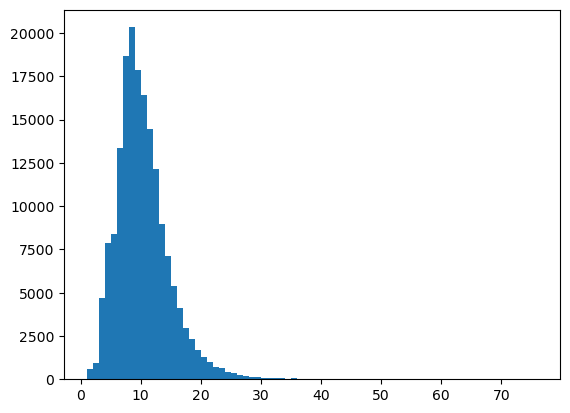

In [16]:
lengths = []
for i, row in dataset.iterrows(): 
    lengths.append(len(str(row["pronunciation"])))

print(np.mean(lengths), np.quantile(lengths, 0.975), np.std(lengths))
print(np.min(lengths), np.max(lengths))
plt.hist(lengths, np.max(lengths) - np.min(lengths))

In [17]:
# Remove any outliers
min_thresh = 3
max_thresh = np.quantile(lengths, 0.975)

work_set = []

for i, row in dataset.iterrows():
    p = str(row["pronunciation"])
    if len(p) >= min_thresh and len(p) <= max_thresh:
        work_set.append(row)

dataset = pd.DataFrame(work_set)

print(len(dataset))

168138


9.543053919994291 18.0 3.6754029967257056
3 20


(array([ 4696.,  7873.,  8383., 13387., 18681., 20337., 17897., 16410.,
        14449., 12159.,  8947.,  7141.,  5362.,  4138.,  2980.,  2303.,
         2995.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20.]),
 <BarContainer object of 17 artists>)

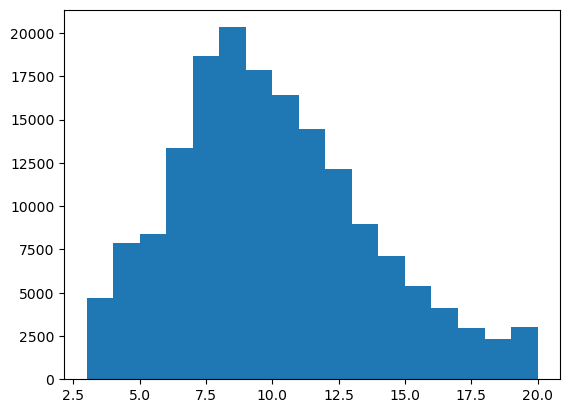

In [18]:
lengths = []
for i, row in dataset.iterrows(): 
    p = str(row["pronunciation"])
    lengths.append(len(p))

print(np.mean(lengths), np.quantile(lengths, 0.975), np.std(lengths))
print(np.min(lengths), np.max(lengths))
plt.hist(lengths, np.max(lengths) - np.min(lengths))

In [19]:
SEQ_LEN = int(np.max(lengths) + 2)
BATCH_SIZE = 1024

<BarContainer object of 76 artists>

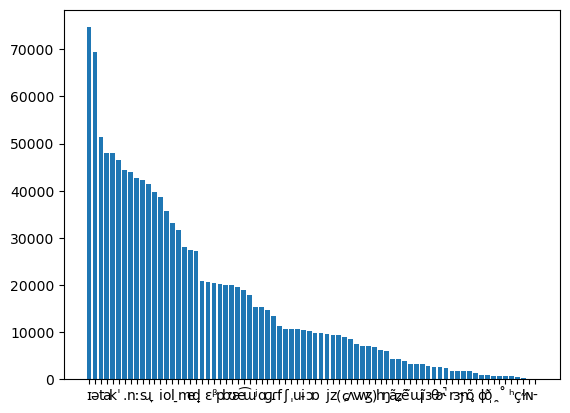

In [20]:
symbols_hist = {}
for i, row in dataset.iterrows():
    d = str(row["pronunciation"])
    for x in d[1:-1]:
        if x in symbols_hist.keys():
            symbols_hist[x] += 1
        else:
            symbols_hist[x] = 1  
sorted_hist =dict(sorted(symbols_hist.items(), key=lambda item: item[1], reverse=True)) 
plt.bar(sorted_hist.keys(), sorted_hist.values())

In [21]:
languages = (1.0 / dataset["language"].value_counts(normalize=True)).to_dict()

In [22]:
phonetics_model = PhoneticTransformer(vocab, SEQ_LEN, languages)
phonetics_model = phonetics_model.to_device(device)

In [23]:
phonetics_dataset = PhoneticsDataset(dataset, pronunciation_tokenizer, SEQ_LEN, BATCH_SIZE)
dataloaders = phonetics_dataset.get_data_loaders()
print(len(dataloaders))

Loading English
Loading Japanese
2


In [24]:
optimizers = {}

for x in languages.keys():
    optimizers[x] = optim.Adam(phonetics_model.get_language_gpt(x).parameters(), lr = 0.0001)

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab.get("[PAD]"))
EPOCHS = 100

for epoch in range(EPOCHS):
    phonetics_model.train()
    for lang, dataloader in dataloaders.items():
        optimizer = optimizers[lang]
        total_loss = 0

        for x in languages.keys():
            languages[x] = float(lang == x)

        model = phonetics_model.get_language_gpt(lang)
        for i, (input_ids, target_ids) in tqdm(enumerate(dataloader), total=len(dataloader)):
            optimizer.zero_grad()
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)
            tgt_mask = generate_square_subsequent_mask(input_ids.size(1)).to(device)

            output = model(input_ids).logits

            loss = criterion(output.permute(0, 2, 1), target_ids)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch: {epoch + 1} Lang: {lang} Train Loss: {total_loss / len(dataloader)}")

    if ((epoch + 1) % 10 == 0):
        torch.save(phonetics_model.state_dict(), f"model{(epoch//10)}")
        

100%|██████████| 118/118 [00:12<00:00,  9.73it/s]


Epoch: 1 Lang: English Train Loss: 3.8324376284065895


100%|██████████| 47/47 [00:04<00:00,  9.97it/s]


Epoch: 1 Lang: Japanese Train Loss: 3.9433812131272985


100%|██████████| 118/118 [00:11<00:00,  9.87it/s]


Epoch: 2 Lang: English Train Loss: 3.299291566266852


100%|██████████| 47/47 [00:04<00:00,  9.61it/s]


Epoch: 2 Lang: Japanese Train Loss: 3.4939050116437547


100%|██████████| 118/118 [00:12<00:00,  9.71it/s]


Epoch: 3 Lang: English Train Loss: 2.984469528925621


100%|██████████| 47/47 [00:04<00:00,  9.69it/s]


Epoch: 3 Lang: Japanese Train Loss: 3.202033352344594


100%|██████████| 118/118 [00:12<00:00,  9.66it/s]


Epoch: 4 Lang: English Train Loss: 2.787917961508541


100%|██████████| 47/47 [00:04<00:00,  9.68it/s]


Epoch: 4 Lang: Japanese Train Loss: 2.954207389912707


100%|██████████| 118/118 [00:12<00:00,  9.67it/s]


Epoch: 5 Lang: English Train Loss: 2.6637493392168463


100%|██████████| 47/47 [00:04<00:00,  9.64it/s]


Epoch: 5 Lang: Japanese Train Loss: 2.736498918939144


100%|██████████| 118/118 [00:13<00:00,  8.63it/s]


Epoch: 6 Lang: English Train Loss: 2.5793458182932967


100%|██████████| 47/47 [00:04<00:00,  9.68it/s]


Epoch: 6 Lang: Japanese Train Loss: 2.540683147755075


100%|██████████| 118/118 [00:12<00:00,  9.56it/s]


Epoch: 7 Lang: English Train Loss: 2.521005784050893


100%|██████████| 47/47 [00:05<00:00,  9.36it/s]


Epoch: 7 Lang: Japanese Train Loss: 2.3641628508872174


100%|██████████| 118/118 [00:12<00:00,  9.58it/s]


Epoch: 8 Lang: English Train Loss: 2.4773537243826915


100%|██████████| 47/47 [00:04<00:00,  9.48it/s]


Epoch: 8 Lang: Japanese Train Loss: 2.2178130809296954


100%|██████████| 118/118 [00:12<00:00,  9.54it/s]


Epoch: 9 Lang: English Train Loss: 2.4454615116119385


100%|██████████| 47/47 [00:04<00:00,  9.58it/s]


Epoch: 9 Lang: Japanese Train Loss: 2.0999637715359953


100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch: 10 Lang: English Train Loss: 2.4181396718752586


100%|██████████| 47/47 [00:05<00:00,  9.29it/s]


Epoch: 10 Lang: Japanese Train Loss: 2.004255436836405


100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch: 11 Lang: English Train Loss: 2.396990408331661


100%|██████████| 47/47 [00:04<00:00,  9.43it/s]


Epoch: 11 Lang: Japanese Train Loss: 1.9272218942642212


100%|██████████| 118/118 [00:12<00:00,  9.49it/s]


Epoch: 12 Lang: English Train Loss: 2.3789854029477655


100%|██████████| 47/47 [00:04<00:00,  9.63it/s]


Epoch: 12 Lang: Japanese Train Loss: 1.8650050087178007


100%|██████████| 118/118 [00:12<00:00,  9.43it/s]


Epoch: 13 Lang: English Train Loss: 2.36331604698957


100%|██████████| 47/47 [00:04<00:00,  9.45it/s]


Epoch: 13 Lang: Japanese Train Loss: 1.815439612307447


100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch: 14 Lang: English Train Loss: 2.34937682394254


100%|██████████| 47/47 [00:05<00:00,  9.23it/s]


Epoch: 14 Lang: Japanese Train Loss: 1.774508740039582


100%|██████████| 118/118 [00:12<00:00,  9.44it/s]


Epoch: 15 Lang: English Train Loss: 2.3377304178173257


100%|██████████| 47/47 [00:06<00:00,  7.28it/s]


Epoch: 15 Lang: Japanese Train Loss: 1.7412610764199115


100%|██████████| 118/118 [00:12<00:00,  9.49it/s]


Epoch: 16 Lang: English Train Loss: 2.326716384645236


100%|██████████| 47/47 [00:04<00:00,  9.47it/s]


Epoch: 16 Lang: Japanese Train Loss: 1.7120417204309017


100%|██████████| 118/118 [00:12<00:00,  9.15it/s]


Epoch: 17 Lang: English Train Loss: 2.3169962531429227


100%|██████████| 47/47 [00:05<00:00,  9.40it/s]


Epoch: 17 Lang: Japanese Train Loss: 1.6876805843190943


100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch: 18 Lang: English Train Loss: 2.3082251791226662


100%|██████████| 47/47 [00:05<00:00,  9.39it/s]


Epoch: 18 Lang: Japanese Train Loss: 1.6669473876344396


100%|██████████| 118/118 [00:12<00:00,  9.42it/s]


Epoch: 19 Lang: English Train Loss: 2.30002374568228


100%|██████████| 47/47 [00:05<00:00,  9.37it/s]


Epoch: 19 Lang: Japanese Train Loss: 1.6480981365163276


100%|██████████| 118/118 [00:12<00:00,  9.41it/s]


Epoch: 20 Lang: English Train Loss: 2.292553663253784


100%|██████████| 47/47 [00:05<00:00,  9.37it/s]


Epoch: 20 Lang: Japanese Train Loss: 1.632764813747812


100%|██████████| 118/118 [00:12<00:00,  9.43it/s]


Epoch: 21 Lang: English Train Loss: 2.2852623745546503


100%|██████████| 47/47 [00:04<00:00,  9.48it/s]


Epoch: 21 Lang: Japanese Train Loss: 1.6187530527723597


100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch: 22 Lang: English Train Loss: 2.2783788462816656


100%|██████████| 47/47 [00:05<00:00,  9.39it/s]


Epoch: 22 Lang: Japanese Train Loss: 1.6055785493647798


100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch: 23 Lang: English Train Loss: 2.2725459276619606


100%|██████████| 47/47 [00:05<00:00,  9.36it/s]


Epoch: 23 Lang: Japanese Train Loss: 1.5937241290477997


100%|██████████| 118/118 [00:12<00:00,  9.40it/s]


Epoch: 24 Lang: English Train Loss: 2.2668582180799066


100%|██████████| 47/47 [00:04<00:00,  9.44it/s]


Epoch: 24 Lang: Japanese Train Loss: 1.5839223506602835


100%|██████████| 118/118 [00:13<00:00,  8.44it/s]


Epoch: 25 Lang: English Train Loss: 2.261176707380909


100%|██████████| 47/47 [00:04<00:00,  9.53it/s]


Epoch: 25 Lang: Japanese Train Loss: 1.5745486832679587


100%|██████████| 118/118 [00:12<00:00,  9.52it/s]


Epoch: 26 Lang: English Train Loss: 2.2562710774146906


100%|██████████| 47/47 [00:05<00:00,  9.34it/s]


Epoch: 26 Lang: Japanese Train Loss: 1.5662632495798963


100%|██████████| 118/118 [00:12<00:00,  9.48it/s]


Epoch: 27 Lang: English Train Loss: 2.2518949347027277


100%|██████████| 47/47 [00:04<00:00,  9.50it/s]


Epoch: 27 Lang: Japanese Train Loss: 1.5578465613913028


100%|██████████| 118/118 [00:12<00:00,  9.43it/s]


Epoch: 28 Lang: English Train Loss: 2.247268549466537


100%|██████████| 47/47 [00:04<00:00,  9.48it/s]


Epoch: 28 Lang: Japanese Train Loss: 1.5503387780899698


100%|██████████| 118/118 [00:12<00:00,  9.40it/s]


Epoch: 29 Lang: English Train Loss: 2.242410833552732


100%|██████████| 47/47 [00:04<00:00,  9.47it/s]


Epoch: 29 Lang: Japanese Train Loss: 1.5439664150806183


100%|██████████| 118/118 [00:12<00:00,  9.46it/s]


Epoch: 30 Lang: English Train Loss: 2.2381192849854292


100%|██████████| 47/47 [00:05<00:00,  9.36it/s]


Epoch: 30 Lang: Japanese Train Loss: 1.537773018187665


100%|██████████| 118/118 [00:12<00:00,  9.46it/s]


Epoch: 31 Lang: English Train Loss: 2.2346123174085455


100%|██████████| 47/47 [00:05<00:00,  9.36it/s]


Epoch: 31 Lang: Japanese Train Loss: 1.5318355509575377


100%|██████████| 118/118 [00:12<00:00,  9.41it/s]


Epoch: 32 Lang: English Train Loss: 2.2314725649558893


100%|██████████| 47/47 [00:04<00:00,  9.45it/s]


Epoch: 32 Lang: Japanese Train Loss: 1.526213714416991


100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch: 33 Lang: English Train Loss: 2.227430107229847


100%|██████████| 47/47 [00:04<00:00,  9.45it/s]


Epoch: 33 Lang: Japanese Train Loss: 1.5219213277735608


100%|██████████| 118/118 [00:13<00:00,  8.46it/s]


Epoch: 34 Lang: English Train Loss: 2.224376092522831


100%|██████████| 47/47 [00:04<00:00,  9.49it/s]


Epoch: 34 Lang: Japanese Train Loss: 1.5170884157748932


100%|██████████| 118/118 [00:12<00:00,  9.44it/s]


Epoch: 35 Lang: English Train Loss: 2.2206607592307916


100%|██████████| 47/47 [00:04<00:00,  9.53it/s]


Epoch: 35 Lang: Japanese Train Loss: 1.5125477060358574


100%|██████████| 118/118 [00:12<00:00,  9.41it/s]


Epoch: 36 Lang: English Train Loss: 2.2179883880130316


100%|██████████| 47/47 [00:04<00:00,  9.57it/s]


Epoch: 36 Lang: Japanese Train Loss: 1.5085056563641162


100%|██████████| 118/118 [00:12<00:00,  9.43it/s]


Epoch: 37 Lang: English Train Loss: 2.214621556007256


100%|██████████| 47/47 [00:04<00:00,  9.47it/s]


Epoch: 37 Lang: Japanese Train Loss: 1.504209520968985


100%|██████████| 118/118 [00:12<00:00,  9.38it/s]


Epoch: 38 Lang: English Train Loss: 2.211800278243372


100%|██████████| 47/47 [00:04<00:00,  9.41it/s]


Epoch: 38 Lang: Japanese Train Loss: 1.5007265983743872


100%|██████████| 118/118 [00:12<00:00,  9.32it/s]


Epoch: 39 Lang: English Train Loss: 2.2090605800434693


100%|██████████| 47/47 [00:05<00:00,  9.22it/s]


Epoch: 39 Lang: Japanese Train Loss: 1.4970784415590002


100%|██████████| 118/118 [00:12<00:00,  9.33it/s]


Epoch: 40 Lang: English Train Loss: 2.2067191519979703


100%|██████████| 47/47 [00:04<00:00,  9.43it/s]


Epoch: 40 Lang: Japanese Train Loss: 1.49383001378242


100%|██████████| 118/118 [00:12<00:00,  9.40it/s]


Epoch: 41 Lang: English Train Loss: 2.2036883810819208


100%|██████████| 47/47 [00:04<00:00,  9.46it/s]


Epoch: 41 Lang: Japanese Train Loss: 1.4904070889696162


100%|██████████| 118/118 [00:14<00:00,  8.43it/s]


Epoch: 42 Lang: English Train Loss: 2.2009011062525086


100%|██████████| 47/47 [00:04<00:00,  9.41it/s]


Epoch: 42 Lang: Japanese Train Loss: 1.4881634078127273


100%|██████████| 118/118 [00:12<00:00,  9.45it/s]


Epoch: 43 Lang: English Train Loss: 2.19918570882183


100%|██████████| 47/47 [00:04<00:00,  9.41it/s]


Epoch: 43 Lang: Japanese Train Loss: 1.4850104032678808


100%|██████████| 118/118 [00:12<00:00,  9.46it/s]


Epoch: 44 Lang: English Train Loss: 2.1967785318019026


100%|██████████| 47/47 [00:04<00:00,  9.41it/s]


Epoch: 44 Lang: Japanese Train Loss: 1.4820209919138159


100%|██████████| 118/118 [00:12<00:00,  9.41it/s]


Epoch: 45 Lang: English Train Loss: 2.194408954200098


100%|██████████| 47/47 [00:04<00:00,  9.57it/s]


Epoch: 45 Lang: Japanese Train Loss: 1.479096881886746


100%|██████████| 118/118 [00:12<00:00,  9.42it/s]


Epoch: 46 Lang: English Train Loss: 2.192617828563108


100%|██████████| 47/47 [00:04<00:00,  9.43it/s]


Epoch: 46 Lang: Japanese Train Loss: 1.4763913814057694


100%|██████████| 118/118 [00:12<00:00,  9.35it/s]


Epoch: 47 Lang: English Train Loss: 2.189984147831545


100%|██████████| 47/47 [00:05<00:00,  9.16it/s]


Epoch: 47 Lang: Japanese Train Loss: 1.4743769321035831


100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Epoch: 48 Lang: English Train Loss: 2.187550118414022


100%|██████████| 47/47 [00:04<00:00,  9.45it/s]


Epoch: 48 Lang: Japanese Train Loss: 1.4723441752981632


100%|██████████| 118/118 [00:12<00:00,  9.38it/s]


Epoch: 49 Lang: English Train Loss: 2.186253889132354


100%|██████████| 47/47 [00:04<00:00,  9.44it/s]


Epoch: 49 Lang: Japanese Train Loss: 1.4698173847604306


100%|██████████| 118/118 [00:12<00:00,  9.40it/s]


Epoch: 50 Lang: English Train Loss: 2.184352230217497


100%|██████████| 47/47 [00:04<00:00,  9.47it/s]


Epoch: 50 Lang: Japanese Train Loss: 1.4671492855599586


100%|██████████| 118/118 [00:13<00:00,  8.48it/s]


Epoch: 51 Lang: English Train Loss: 2.1814846204499068


100%|██████████| 47/47 [00:04<00:00,  9.50it/s]


Epoch: 51 Lang: Japanese Train Loss: 1.4655562816782202


100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch: 52 Lang: English Train Loss: 2.1800851498619984


100%|██████████| 47/47 [00:05<00:00,  9.23it/s]


Epoch: 52 Lang: Japanese Train Loss: 1.4634043916742852


100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch: 53 Lang: English Train Loss: 2.1782259759256397


100%|██████████| 47/47 [00:04<00:00,  9.42it/s]


Epoch: 53 Lang: Japanese Train Loss: 1.461395152071689


100%|██████████| 118/118 [00:12<00:00,  9.42it/s]


Epoch: 54 Lang: English Train Loss: 2.1768436149015264


100%|██████████| 47/47 [00:05<00:00,  9.39it/s]


Epoch: 54 Lang: Japanese Train Loss: 1.4594922826645222


100%|██████████| 118/118 [00:12<00:00,  9.44it/s]


Epoch: 55 Lang: English Train Loss: 2.1747944031731556


100%|██████████| 47/47 [00:04<00:00,  9.44it/s]


Epoch: 55 Lang: Japanese Train Loss: 1.4582807764093926


100%|██████████| 118/118 [00:12<00:00,  9.47it/s]


Epoch: 56 Lang: English Train Loss: 2.1734498678627663


100%|██████████| 47/47 [00:04<00:00,  9.47it/s]


Epoch: 56 Lang: Japanese Train Loss: 1.4564815049475812


100%|██████████| 118/118 [00:12<00:00,  9.40it/s]


Epoch: 57 Lang: English Train Loss: 2.1715017274274664


100%|██████████| 47/47 [00:04<00:00,  9.44it/s]


Epoch: 57 Lang: Japanese Train Loss: 1.4551017081483881


100%|██████████| 118/118 [00:12<00:00,  9.44it/s]


Epoch: 58 Lang: English Train Loss: 2.169816386901726


100%|██████████| 47/47 [00:04<00:00,  9.54it/s]


Epoch: 58 Lang: Japanese Train Loss: 1.4527941079849893


100%|██████████| 118/118 [00:14<00:00,  8.42it/s]


Epoch: 59 Lang: English Train Loss: 2.1682165881334723


100%|██████████| 47/47 [00:04<00:00,  9.50it/s]


Epoch: 59 Lang: Japanese Train Loss: 1.4521862243084198


100%|██████████| 118/118 [00:12<00:00,  9.38it/s]


Epoch: 60 Lang: English Train Loss: 2.166455957849147


100%|██████████| 47/47 [00:04<00:00,  9.42it/s]


Epoch: 60 Lang: Japanese Train Loss: 1.4502443125907412


100%|██████████| 118/118 [00:12<00:00,  9.44it/s]


Epoch: 61 Lang: English Train Loss: 2.1642360909510465


100%|██████████| 47/47 [00:04<00:00,  9.49it/s]


Epoch: 61 Lang: Japanese Train Loss: 1.4484338912558048


100%|██████████| 118/118 [00:12<00:00,  9.43it/s]


Epoch: 62 Lang: English Train Loss: 2.163538451922142


100%|██████████| 47/47 [00:04<00:00,  9.44it/s]


Epoch: 62 Lang: Japanese Train Loss: 1.4464435298392113


100%|██████████| 118/118 [00:12<00:00,  9.40it/s]


Epoch: 63 Lang: English Train Loss: 2.1624550395092723


100%|██████████| 47/47 [00:05<00:00,  9.38it/s]


Epoch: 63 Lang: Japanese Train Loss: 1.4455079550438739


100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch: 64 Lang: English Train Loss: 2.16039621021788


100%|██████████| 47/47 [00:05<00:00,  9.23it/s]


Epoch: 64 Lang: Japanese Train Loss: 1.4440939857604655


100%|██████████| 118/118 [00:12<00:00,  9.28it/s]


Epoch: 65 Lang: English Train Loss: 2.1589157116615167


100%|██████████| 47/47 [00:04<00:00,  9.51it/s]


Epoch: 65 Lang: Japanese Train Loss: 1.4425491246771305


100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch: 66 Lang: English Train Loss: 2.157589185035835


100%|██████████| 47/47 [00:05<00:00,  9.39it/s]


Epoch: 66 Lang: Japanese Train Loss: 1.4413029817824667


100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch: 67 Lang: English Train Loss: 2.1564662193847917


100%|██████████| 47/47 [00:06<00:00,  7.19it/s]


Epoch: 67 Lang: Japanese Train Loss: 1.440032294455995


100%|██████████| 118/118 [00:12<00:00,  9.29it/s]


Epoch: 68 Lang: English Train Loss: 2.1546153092788436


100%|██████████| 47/47 [00:05<00:00,  9.35it/s]


Epoch: 68 Lang: Japanese Train Loss: 1.438776690909203


100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch: 69 Lang: English Train Loss: 2.1533497268870727


100%|██████████| 47/47 [00:05<00:00,  9.36it/s]


Epoch: 69 Lang: Japanese Train Loss: 1.4382771963768817


100%|██████████| 118/118 [00:12<00:00,  9.29it/s]


Epoch: 70 Lang: English Train Loss: 2.152289988630909


100%|██████████| 47/47 [00:05<00:00,  9.33it/s]


Epoch: 70 Lang: Japanese Train Loss: 1.4369027639957184


100%|██████████| 118/118 [00:12<00:00,  9.33it/s]


Epoch: 71 Lang: English Train Loss: 2.1512249081821766


100%|██████████| 47/47 [00:04<00:00,  9.52it/s]


Epoch: 71 Lang: Japanese Train Loss: 1.4354187123318936


100%|██████████| 118/118 [00:12<00:00,  9.31it/s]


Epoch: 72 Lang: English Train Loss: 2.149403705435284


100%|██████████| 47/47 [00:05<00:00,  9.28it/s]


Epoch: 72 Lang: Japanese Train Loss: 1.434760666908102


100%|██████████| 118/118 [00:12<00:00,  9.35it/s]


Epoch: 73 Lang: English Train Loss: 2.1486170534360207


100%|██████████| 47/47 [00:05<00:00,  9.30it/s]


Epoch: 73 Lang: Japanese Train Loss: 1.4335758432428887


100%|██████████| 118/118 [00:12<00:00,  9.19it/s]


Epoch: 74 Lang: English Train Loss: 2.1471922256178777


100%|██████████| 47/47 [00:05<00:00,  9.32it/s]


Epoch: 74 Lang: Japanese Train Loss: 1.4321568240510656


100%|██████████| 118/118 [00:12<00:00,  9.32it/s]


Epoch: 75 Lang: English Train Loss: 2.1461137654417652


100%|██████████| 47/47 [00:05<00:00,  9.28it/s]


Epoch: 75 Lang: Japanese Train Loss: 1.4314354455217402


100%|██████████| 118/118 [00:14<00:00,  8.31it/s]


Epoch: 76 Lang: English Train Loss: 2.145171797881692


100%|██████████| 47/47 [00:05<00:00,  9.16it/s]


Epoch: 76 Lang: Japanese Train Loss: 1.430515596207152


100%|██████████| 118/118 [00:12<00:00,  9.28it/s]


Epoch: 77 Lang: English Train Loss: 2.1440703585996466


100%|██████████| 47/47 [00:04<00:00,  9.41it/s]


Epoch: 77 Lang: Japanese Train Loss: 1.4294527794452423


100%|██████████| 118/118 [00:12<00:00,  9.33it/s]


Epoch: 78 Lang: English Train Loss: 2.1427110655833097


100%|██████████| 47/47 [00:05<00:00,  9.27it/s]


Epoch: 78 Lang: Japanese Train Loss: 1.4284034206512126


100%|██████████| 118/118 [00:12<00:00,  9.16it/s]


Epoch: 79 Lang: English Train Loss: 2.1413242150161227


100%|██████████| 47/47 [00:05<00:00,  9.30it/s]


Epoch: 79 Lang: Japanese Train Loss: 1.4268675002645939


100%|██████████| 118/118 [00:12<00:00,  9.29it/s]


Epoch: 80 Lang: English Train Loss: 2.1406446856967474


100%|██████████| 47/47 [00:05<00:00,  9.30it/s]


Epoch: 80 Lang: Japanese Train Loss: 1.4268708457338048


100%|██████████| 118/118 [00:12<00:00,  9.23it/s]


Epoch: 81 Lang: English Train Loss: 2.1395442768678827


100%|██████████| 47/47 [00:05<00:00,  9.24it/s]


Epoch: 81 Lang: Japanese Train Loss: 1.4258343792976218


100%|██████████| 118/118 [00:12<00:00,  9.21it/s]


Epoch: 82 Lang: English Train Loss: 2.138262566873583


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]


Epoch: 82 Lang: Japanese Train Loss: 1.4249907655918852


100%|██████████| 118/118 [00:12<00:00,  9.12it/s]


Epoch: 83 Lang: English Train Loss: 2.137188755859763


100%|██████████| 47/47 [00:05<00:00,  9.24it/s]


Epoch: 83 Lang: Japanese Train Loss: 1.4245413896885324


100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Epoch: 84 Lang: English Train Loss: 2.135630474252216


100%|██████████| 47/47 [00:05<00:00,  9.12it/s]


Epoch: 84 Lang: Japanese Train Loss: 1.4232844925941306


100%|██████████| 118/118 [00:12<00:00,  9.10it/s]


Epoch: 85 Lang: English Train Loss: 2.134709216780582


100%|██████████| 47/47 [00:05<00:00,  9.29it/s]


Epoch: 85 Lang: Japanese Train Loss: 1.4221122315589418


100%|██████████| 118/118 [00:14<00:00,  8.30it/s]


Epoch: 86 Lang: English Train Loss: 2.1339401451207825


100%|██████████| 47/47 [00:05<00:00,  9.27it/s]


Epoch: 86 Lang: Japanese Train Loss: 1.4213476231757631


100%|██████████| 118/118 [00:12<00:00,  9.28it/s]


Epoch: 87 Lang: English Train Loss: 2.1330829858779907


100%|██████████| 47/47 [00:05<00:00,  9.24it/s]


Epoch: 87 Lang: Japanese Train Loss: 1.4210182073268485


100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Epoch: 88 Lang: English Train Loss: 2.131948923660537


100%|██████████| 47/47 [00:05<00:00,  9.24it/s]


Epoch: 88 Lang: Japanese Train Loss: 1.4199106464994715


100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Epoch: 89 Lang: English Train Loss: 2.131359185202647


100%|██████████| 47/47 [00:05<00:00,  9.27it/s]


Epoch: 89 Lang: Japanese Train Loss: 1.419215646195919


100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Epoch: 90 Lang: English Train Loss: 2.1300589876659846


100%|██████████| 47/47 [00:05<00:00,  9.33it/s]


Epoch: 90 Lang: Japanese Train Loss: 1.4183606923894678


100%|██████████| 118/118 [00:12<00:00,  9.19it/s]


Epoch: 91 Lang: English Train Loss: 2.128951753600169


100%|██████████| 47/47 [00:05<00:00,  9.33it/s]


Epoch: 91 Lang: Japanese Train Loss: 1.4178973537810304


100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch: 92 Lang: English Train Loss: 2.1276688696974415


100%|██████████| 47/47 [00:05<00:00,  9.21it/s]


Epoch: 92 Lang: Japanese Train Loss: 1.4169991270024727


100%|██████████| 118/118 [00:12<00:00,  9.20it/s]


Epoch: 93 Lang: English Train Loss: 2.127232135352442


100%|██████████| 47/47 [00:05<00:00,  9.23it/s]


Epoch: 93 Lang: Japanese Train Loss: 1.4155564790076398


100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch: 94 Lang: English Train Loss: 2.126535821769197


100%|██████████| 47/47 [00:06<00:00,  7.11it/s]


Epoch: 94 Lang: Japanese Train Loss: 1.4154874898017722


100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch: 95 Lang: English Train Loss: 2.124798508013709


100%|██████████| 47/47 [00:05<00:00,  9.33it/s]


Epoch: 95 Lang: Japanese Train Loss: 1.4143419773020642


100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch: 96 Lang: English Train Loss: 2.1245153051311685


100%|██████████| 47/47 [00:05<00:00,  9.39it/s]


Epoch: 96 Lang: Japanese Train Loss: 1.4139445030942877


100%|██████████| 118/118 [00:12<00:00,  9.22it/s]


Epoch: 97 Lang: English Train Loss: 2.1235059297690957


100%|██████████| 47/47 [00:05<00:00,  9.31it/s]


Epoch: 97 Lang: Japanese Train Loss: 1.4136500840491437


100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch: 98 Lang: English Train Loss: 2.1231441416982877


100%|██████████| 47/47 [00:05<00:00,  9.28it/s]


Epoch: 98 Lang: Japanese Train Loss: 1.4134920860858673


100%|██████████| 118/118 [00:12<00:00,  9.25it/s]


Epoch: 99 Lang: English Train Loss: 2.1220847428855247


100%|██████████| 47/47 [00:05<00:00,  9.33it/s]


Epoch: 99 Lang: Japanese Train Loss: 1.4121004165487085


100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Epoch: 100 Lang: English Train Loss: 2.1209159139859475


100%|██████████| 47/47 [00:05<00:00,  9.28it/s]

Epoch: 100 Lang: Japanese Train Loss: 1.4119329756878791


In [43]:
def generate(model, pad_token_id, top_k = 50, top_p = 0.95, temperature = 1.0):
    input_ids = pronunciation_tokenizer.encode("").ids[:-1]
    input_ids = [input_ids]
    input_ids = torch.tensor(input_ids, dtype = torch.long)
    input_ids = input_ids.to(device)
    tgt_mask = generate_square_subsequent_mask(input_ids.size(1)).to(device)

    output = model.generate(
        input_ids,
        pad_token_id = pad_token_id,
        no_repeat_ngram_size=0,  # Prevent repetition
        do_sample = True,
        top_k=top_k,  # Limits the sampling pool to top_k tokens
        top_p=top_p,  # Cumulative probability for nucleus sampling
        temperature=temperature,  # Adjust the randomness of predictions,
    )
    output = pronunciation_tokenizer.decode(output[0][1:-1].cpu().numpy())
    return output

In [50]:
phonetics_model = PhoneticTransformer(vocab, SEQ_LEN, languages)
phonetics_model.load_state_dict(torch.load("model9"))
phonetics_model.to(device)
phonetics_model.eval()
languages = {
    "English" : 1.0,
    "Japanese": 1.0,
}
phonetics_model.set_language_weights(languages)
for _ in range(10):
    o = generate(phonetics_model, vocab["[PAD]"], top_k=50, top_p=0.95, temperature=1.0)
    print(o)

C:\Users\Joaquin\AppData\Local\Temp\ipykernel_24820\1545520404.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  phonetics_model.load_state_dict(torch.load("model9"))


ka̠it͡ɕi
ɾʲa̠kɯ̟ᵝe̞ɾɯ̟ᵝ
jaɚmi ɡa
ekame
sɨkʰi
tafːku
jaŋzi d̯
auːbu
sandon
pa̠


In [ ]:
pronunciation_tokenizer.save_pretrained("C:\\Users\\Joaquin\\Desktop\\Playground\\ML\\ChaosLang\\models")